In [ ]:
import os
import pandas as pd
import numpy as np
from google.cloud import storage
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import gc


In [ ]:
# if run locally
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
os.chdir('drive')
os.chdir('My Drive')
os.chdir('Colab Notebooks')
print(os.getcwd())

In [ ]:
JSONcredential = "key_storage_dl-orderbook.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = JSONcredential

In [ ]:
#Create client to bundle configuration needed for API requests.
storage_client = storage.client.Client()

#Or create object to existing bucket
bucket = storage_client.get_bucket('bucket_l2_snapshot')

# blob = bucket.blob('l2_snapshot_100ms.csv')

In [ ]:
df = pd.read_csv('gs://bucket_l2_snapshot/l2_snapshot_100ms.csv', index_col=0, infer_datetime_format=True)

In [ ]:
df.index = pd.to_datetime(df.index)

In [ ]:
def concat_data(base_path, features):
    """Concatenate all the files in basepath keeping only the
    columns specified by features.
    """
    l2_snapshot = pd.DataFrame()
    for i, x in enumerate(tqdm(sorted(os.listdir(base_path)))):
      if base_path is None:
        path = x
      else:
        path = base_path + x
      df_hour = pd.read_parquet(path, columns=features)
      l2_snapshot = pd.concat([l2_snapshot, df_hour.dropna()])
        
    return l2_snapshot

def extend_matrix(A, n):
    """Extend a matrix A by duplicating rows as specified by the list n."""
    n = n[1:]  # Do not duplicate rows for the first day
    A = A[:-1]  # Do not duplicate the last day's row
    A = np.repeat(A, repeats=n, axis=0)
    return A

def normalise_data_per_day(df):
    df_mean = df.resample('D').mean()
    df_var = df.resample('D').var()
    
    timestamps_per_day = np.unique(df.index.date, return_counts=True)[1]
    mean_array = extend_matrix(df_mean.to_numpy(), timestamps_per_day)
    var_array = extend_matrix(df_var.to_numpy(), timestamps_per_day)
    
    # Drop the rows of the first day
    df = df[df.index.date != df.index[0].date()]
    
    df = (df - mean_array) / np.sqrt(var_array)

    return df

def balance_classes(y):
    unique = np.unique(y, return_counts=True)

    # Take smallest number as class size
    class_size = np.min(unique[1])
    class_size_index = np.argmin(unique[1])
    timestamps = np.array([], dtype=int)
    for i, category in enumerate(unique[0]):
        if i == class_size_index:
            continue
        index = np.argwhere(y==category)
        index = index.reshape(len(index))
        random_timestamps = np.random.choice(index, (unique[1][i] - class_size), replace=False)
        timestamps = np.concatenate((timestamps, random_timestamps), axis=None)
        
    return timestamps

def generate_y(df_snapshot, T=100, D=40, best_ask='a1', best_bid='b1', k=20, alpha=10e-5):
    """Return X, y from the snapshot dataframe and the best ask/bid columns."""
    df = pd.DataFrame()
    df['mid_price'] = (df_snapshot[best_ask].to_numpy()+df_snapshot[best_bid].to_numpy())/2

    # Create columns delayed by -k to k-1
    for i in range(-k, k):
        df[i] = df['mid_price'].shift(periods=i)

    # Drop first k-1 rows and last k rows
    df.drop(range(0,20), axis=0, inplace=True)
    df.drop(range(len(df_snapshot)-20,len(df_snapshot)), axis=0, inplace=True)
    
    # Compute mean of previous k and next k
    df['m_b'] = df[range(0,20)].mean(axis=1)
    df['m_a'] = df[range(-20,0)].mean(axis=1)
    
    # Compute label of increasing or decreasing
    y_increase = np.where(df['m_b'] > df['m_a'] * (1+alpha), 1, 0)
    y_decrease = np.where(df['m_b'] < df['m_a'] * (1-alpha), -1, 0)
    y = y_increase + y_decrease

    # 100 most recent limit orders used so ignore first 100 timesteps
    y = y[T:]
    y += 1

    return y

def generate_preX(df_snapshot):
    preX = df_snapshot.to_numpy()[20:-20]

    return preX

def generate_X(preX, T=100, D=40):
    # For each timestep create matrix of 100 most recent limit orders
    X = np.array([preX[t:t+T] for t in range(len(preX)-T)], dtype='float32')
        
    return X

In [ ]:
features = ['b1','b2','b3','b4','b5','b6','b7','b8', 'b9', 'b10', 'a1','a2','a3','a4','a5','a6','a7','a8', 'a9', 'a10', 'bq1','bq2','bq3','bq4','bq5','bq6','bq7','bq8', 'bq9', 'bq10', 'aq1','aq2','aq3','aq4','aq5','aq6','aq7','aq8', 'aq9', 'aq10']
#l2_snapshot = concat_data(None, features)

In [ ]:
# l2_snapshot.to_csv("l2_snapshot_100ms.csv")
# l2_snapshot = pd.read_csv("l2_snapshot_100ms.csv", index_col=0, parse_dates=True)

In [ ]:
# takes 70 seconds
l2_norm = normalise_data_per_day(df)

In [ ]:
del df

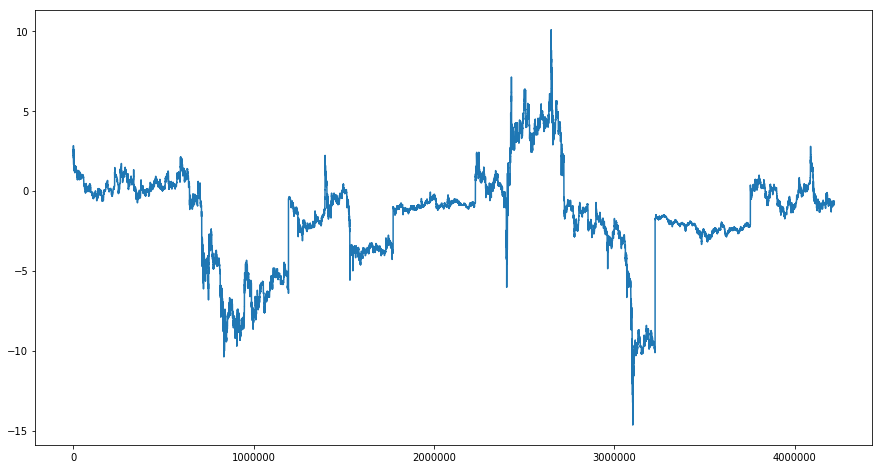

In [ ]:
# Careful, if run must delete `mid_price` before creating preX dataset
l2_norm['mid_price'] = (l2_norm['a1']+l2_norm['b1'])/2

plt.figure(figsize = (15,8))
plt.plot(np.arange(1,l2_norm.shape[0]+1), l2_norm['mid_price'])
plt.show()

In [ ]:
print(np.unique(y, return_counts=True)[1])
sns.countplot(x = y)
plt.show()

In [ ]:
# First create input dataset and then undersample to have balanced classes
# Train test validate split 

In [ ]:
T = 100
D = 40
y = generate_y(l2_norm, T=T, D=D, best_ask='a1', best_bid = 'b1', alpha=0.002)
preX = generate_preX(l2_norm)
print(preX.shape)

(4220032, 40)


In [ ]:
del l2_norm
gc.collect()

0

In [ ]:
X = generate_X(preX)
print(X.shape, y.shape)
print(np.unique(y))

(4219932, 100, 40) (4219932,)
[0 1 2]


In [ ]:
del preX
gc.collect()

0

In [ ]:
# Balance out the classes by taking the number of the smallest class
timestamps_to_delete = balance_classes(y)
print(len(timestamps_to_delete))
X = np.delete(X, timestamps_to_delete, axis=0)
y = np.delete(y, timestamps_to_delete, axis=0)

2538525


In [ ]:
print(X.shape, y.shape)
print(np.unique(y, return_counts=True))

(1681407, 100, 40) (1681407,)
(array([0, 1, 2]), array([560469, 560469, 560469]))


In [ ]:
X_train, X_test_validation, y_train, y_test_validation = train_test_split(
    X, y, test_size=0.15, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(
    X_test_validation, y_test_validation, test_size=0.33, random_state=42)

In [ ]:
del X, y, X_test_validation, y_test_validation
gc.collect()

0

In [ ]:
print('X_train - Before: {} GB'.format(X_train.nbytes/1024**3), X_train.dtype)
print('y_train - Before: {} GB'.format(y_train.nbytes/1024**3), y_train.dtype)
print('X_validation - Before: {} GB'.format(X_validation.nbytes/1024**3), X_validation.dtype)
print('y_validation - Before: {} GB'.format(y_validation.nbytes/1024**3), y_validation.dtype)
print('X_test - Before: {} GB'.format(X_test.nbytes/1024**3), X_test.dtype)
print('y_test - Before: {} GB'.format(y_test.nbytes/1024**3), y_test.dtype)

X_train - Before: 21.2966650724411 GB float32
y_train - Before: 0.01064833253622055 GB int64
X_validation - Before: 2.5180280208587646 GB float32
y_validation - Before: 0.0012590140104293823 GB int64
X_test - Before: 1.2402236461639404 GB float32
y_test - Before: 0.0006201118230819702 GB int64


In [ ]:
X_train.shape, y_train.shape

((1429195, 100, 40), (1429195,))

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [ ]:
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [ ]:
# !pip install tensorflow-addons

In [ ]:
# import tensorflow_addons as tfa

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D, Dense, LeakyReLU, Bidirectional, LSTM, Add, Activation, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [ ]:
from tensorflow import keras
from functools import partial

In [ ]:
DefaultConv1D = partial(keras.layers.Conv1D, kernel_size=4, strides=1,
                        padding="SAME", use_bias=False)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    inputs = keras.layers.Input(shape = (100,40))
    x = keras.layers.Conv1D(filters=16, kernel_size=4 ,activation='relu', padding='SAME')(inputs)
    x = keras.layers.MaxPooling1D(2)(x)
    
    prev_filters = 16
    for filters in [16]*3+[32]*2:
        if prev_filters != filters:
            stride = 2
            shortcut = DefaultConv1D(filters, kernel_size=1, strides=stride)(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)
        else:
            stride = 1
            shortcut = x

        x = DefaultConv1D(filters, strides=stride)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = DefaultConv1D(filters)(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Add()([shortcut, x])
        x = keras.layers.Activation('relu')(x)

        prev_filters = filters

    x = keras.layers.GlobalAveragePooling1D()(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)
    
    res_net_model = keras.models.Model(inputs, outputs)
    opt = keras.optimizers.Adam(learning_rate=0.001)  # Default is 0.001
    res_net_model.compile(optimizer=opt,
               loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

In [ ]:
keras.utils.plot_model(res_net_model, 'plot_model_0.png', show_shapes=True, rankdir='TB')

blob = bucket.blob('plot_model_0')
blob.upload_from_filename('plot_model_0.png')

In [ ]:
# res_net_model = tf.keras.models.load_model('model_0.h5')

In [ ]:
EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=4)
model_save_checkpoint = keras.callbacks.ModelCheckpoint(
                            filepath='models/model_resnet_1.h5',
                            save_best_only=True,
                            monitor='val_loss',
                            verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=2,
                verbose=1,
                min_lr=0.0001)
callbacks = [reduce_lr, model_save_checkpoint, early_stop]
history = res_net_model.fit(
            X_train,y_train,
            epochs=EPOCHS,
            batch_size=128,
            callbacks=callbacks,
            validation_data = (X_validation, y_validation),
)

hist = pd.DataFrame(history.history)
hist.to_csv('hist_model_1.csv')

Train on 1429195 samples, validate on 168982 samples
Epoch 1/1000
INFO:tensorflow:batch_all_reduce: 37 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 37 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
1429120/1429195 [============================>.] - ETA: 0s - loss: 0.7329 - accuracy: 0.6622
Epoch 00001: val_loss improved from inf to 0.69187, saving model to models/model_resnet_1.h5
1429195/1429195 [==============================] - 262s 183us/sample - loss: 0.7329 - accuracy: 0.6622 - val_loss: 0.6919 - val_accuracy: 0.6855
Epoch 2/1000
1428864/1429195 [============================>.] - ETA: 0s - loss: 0.6708 - accuracy: 0.6979
Epoch 00002: val_loss improved from 0.69187 to 0.65391, saving model to models/model_resnet_1.h5
1429195/1429195 [==============================] - 215s 150us/sample - loss: 0.6708 - accuracy: 

In [ ]:
# res_net_model.save('model_resnet_early_stopping.h5')

INFO:tensorflow:Assets written to: model_epoch5_alpha_early/assets


KeyError: ignored

In [ ]:
# hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,accuracy,loss,lr,val_accuracy,val_loss,epoch
52,0.752099,0.564113,0.0001,0.753423,0.560456,52
53,0.752196,0.563841,0.0001,0.753518,0.561269,53
54,0.752601,0.563348,0.0001,0.754051,0.560977,54
55,0.752160,0.563240,0.0001,0.753613,0.561686,55
56,0.752522,0.562858,0.0001,0.753814,0.560985,56


In [ ]:
hist.to_csv('hist_model_0_1.csv')

No handles with labels found to put in legend.


Text(0, 0.5, 'Sparse Categorical Crossentropy')

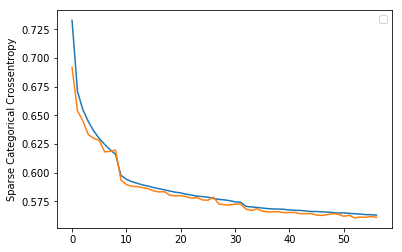

In [ ]:
plt.plot(hist[['loss', 'val_loss']])
plt.legend()
# plt.ylim([0, 10])
plt.ylabel('Sparse Categorical Crossentropy')

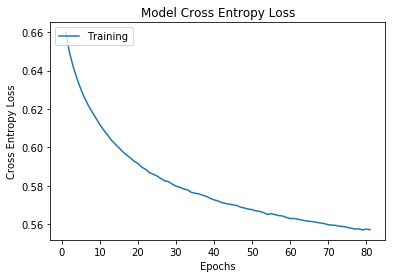

In [ ]:
sns.lineplot(x=range(1,+1),y=histor.history['loss'])
#sns.lineplot(x=range(1,EPOCHS+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training'], loc='upper left')

In [ ]:
y_pred = res_net_model.predict(X_test)

In [ ]:
y_pred = y_pred.argmax(axis=1)

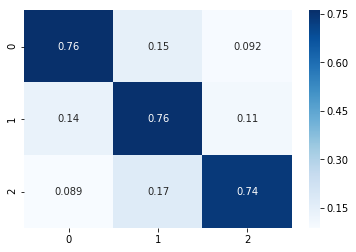

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax=sns.heatmap(cm, annot=True, xticklabels=[0,1,2], yticklabels=[0,1,2], cmap='Blues')
ax.set_ylim(3.0, 0)
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.77      0.76      0.77     27807
          1       0.70      0.76      0.73     27698
          2       0.79      0.74      0.76     27725

avg / total       0.75      0.75      0.75     83230



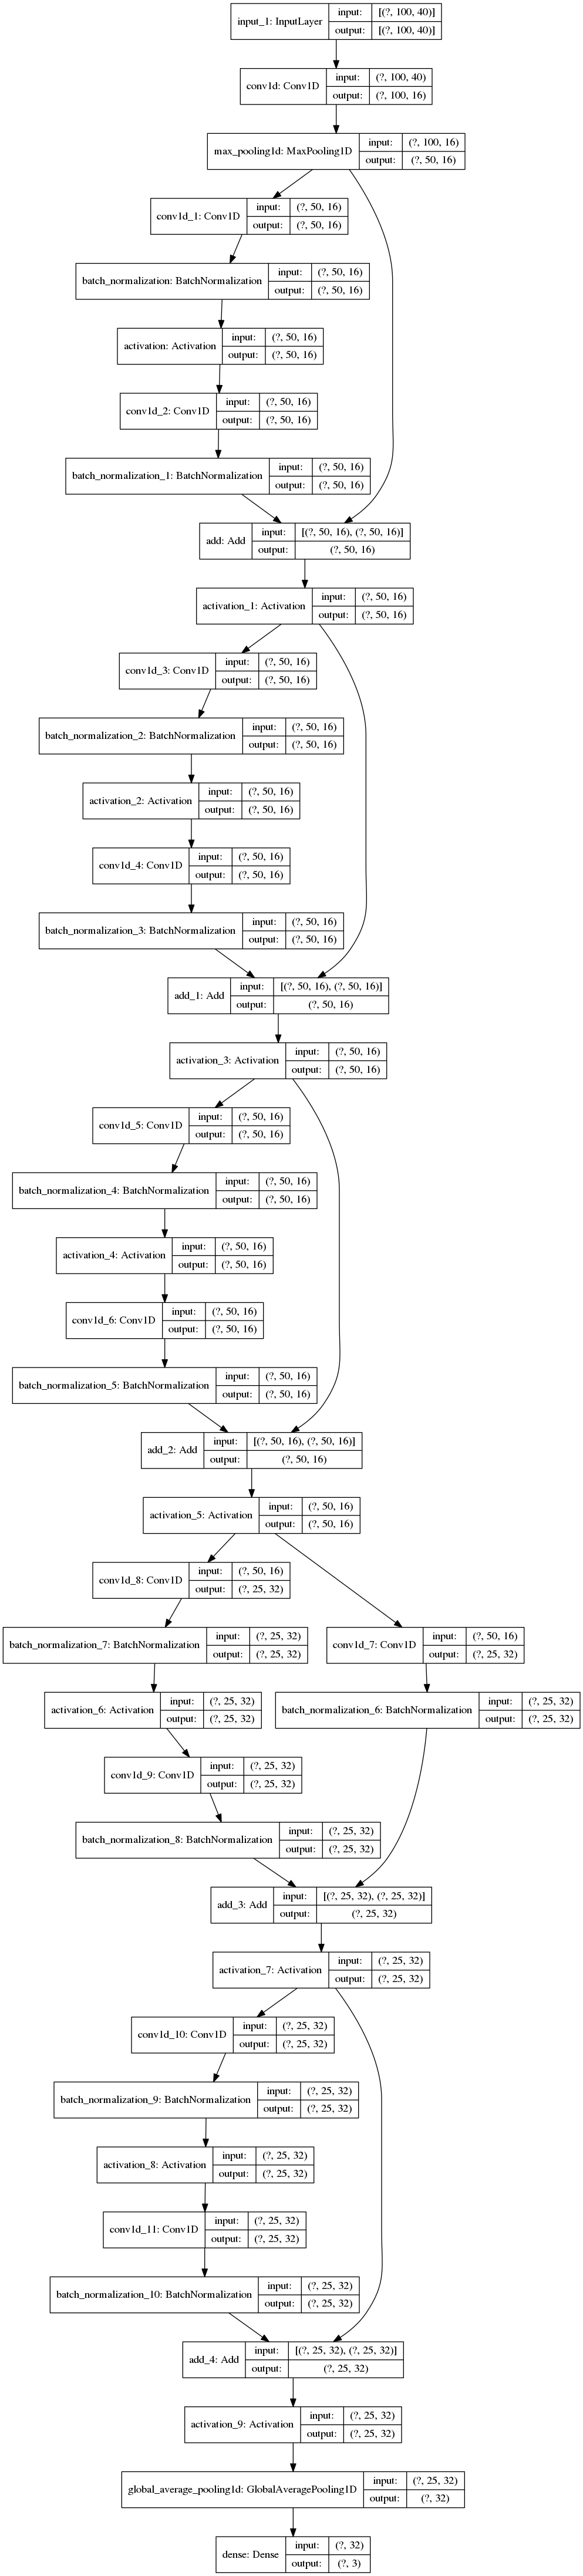

In [ ]:
keras.utils.plot_model(res_net_model, 'plot_model_0.png', show_shapes=True, rankdir='TB')


In [ ]:
blob = bucket.blob('model_resnet')
blob.upload_from_filename('models/model_resnet_1.h5')

blob_2 = bucket.blob('history_training')
blob_2.upload_from_filename('hist_model_1.csv')